In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
meta_df = pd.read_csv("../data/study1_novel/fiction_regression_df.csv")

In [7]:
genres = ["war", "biography", "romance", "drama", "fantasy", "family", 
          "science", "action", "thriller", "western", "horror", 
          "mystery", "crime", "history", "christian"]

In [3]:
transformed_downloads, lambda_value = stats.boxcox(meta_df.downloads)
meta_df["transformed_downloads"] = transformed_downloads
print(lambda_value)

-0.47391728532745225


In [4]:
meta_df[["downloads", "transformed_downloads", "downloads", 
         "n_nodes", "n_edges",  "network_density", "modularity",
         "average_clustering", "average_shortest_path_largest_component"]].describe()

,downloads,transformed_downloads,downloads,n_nodes,n_edges,network_density,modularity,average_clustering,average_shortest_path_largest_component
count,10603.000000,10603.000000,10603.000000,10603.000000,10603.000000,10603.000000,10603.000000,10603.000000,10603.000000
mean,160.742714,1.819373,160.742714,30.864095,48.017825,0.137421,0.277948,0.040817,2.556612
std,1109.689708,0.087717,1109.689708,18.812389,35.186173,0.095651,0.143840,0.037424,0.493470
min,8.000000,1.322470,8.000000,3.000000,2.000000,0.008057,0.000000,0.000000,1.000000
25%,46.000000,1.766287,46.000000,18.000000,24.000000,0.080193,0.174486,0.019719,2.280702
50%,65.000000,1.818245,65.000000,28.000000,42.000000,0.110837,0.262857,0.033485,2.502674
75%,101.000000,1.873255,101.000000,39.000000,63.000000,0.158333,0.370102,0.053009,2.758404
max,42584.000000,2.096570,42584.000000,323.000000,419.000000,1.000000,0.830796,1.000000,7.297872


In [5]:
formula = "transformed_downloads ~ n_nodes  + network_density  + modularity + average_clustering + average_shortest_path_largest_component"
print(formula)
md = smf.ols(formula, meta_df)
mdf = md.fit()
print(mdf.summary())

transformed_downloads ~ n_nodes  + network_density  + modularity + average_clustering + average_shortest_path_largest_component
                              OLS Regression Results                             
Dep. Variable:     transformed_downloads   R-squared:                       0.022
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     48.22
Date:                   Sun, 23 Nov 2025   Prob (F-statistic):           1.65e-49
Time:                           22:19:48   Log-Likelihood:                 10879.
No. Observations:                  10603   AIC:                        -2.175e+04
Df Residuals:                      10597   BIC:                        -2.170e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                              coef  

In [8]:
formula = "transformed_downloads ~ authoryearofbirth + log_N_tokens + log_N_sentences" + \
             " + n_nodes   + network_density + modularity + average_clustering + average_shortest_path_largest_component" + \
                " + " +\
             " + " + " + ".join(["genre_"+g for g in genres])
print(formula)
md = smf.ols(formula, meta_df)
mdf = md.fit()
print(mdf.summary())

transformed_downloads ~ authoryearofbirth + log_N_tokens + log_N_sentences + n_nodes   + network_density + modularity + average_clustering + average_shortest_path_largest_component +  + genre_war + genre_biography + genre_romance + genre_drama + genre_fantasy + genre_family + genre_science + genre_action + genre_thriller + genre_western + genre_horror + genre_mystery + genre_crime + genre_history + genre_christian
                              OLS Regression Results                             
Dep. Variable:     transformed_downloads   R-squared:                       0.096
Model:                               OLS   Adj. R-squared:                  0.094
Method:                    Least Squares   F-statistic:                     48.59
Date:                   Sun, 23 Nov 2025   Prob (F-statistic):          4.16e-210
Time:                           22:20:10   Log-Likelihood:                 11292.
No. Observations:                  10603   AIC:                        -2.254e+04
Df Resid

[]

<Figure size 700x500 with 0 Axes>

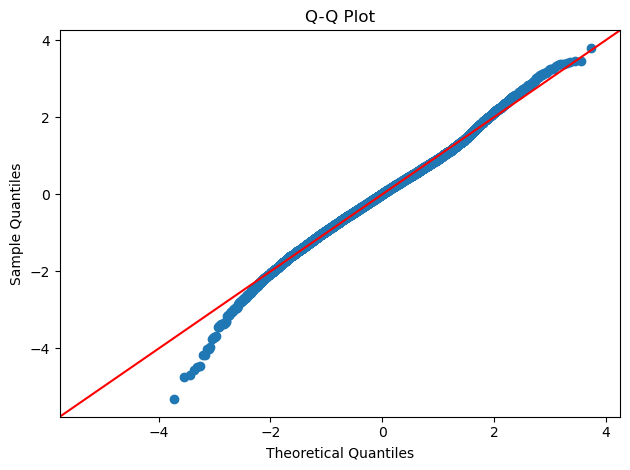

In [9]:

plt.figure(figsize=(7, 5))
sm.qqplot(mdf.resid, fit=True, line="45")
plt.title('Q-Q Plot')
plt.tight_layout()
plt.plot()

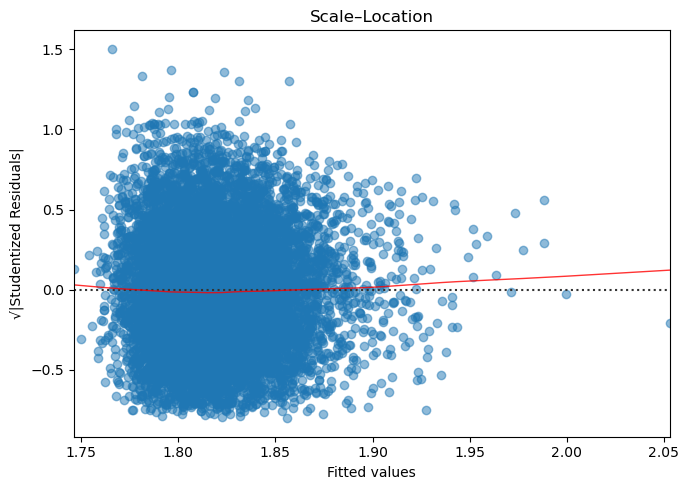

In [10]:
influence = mdf.get_influence()
studentized_resid = influence.resid_studentized_internal

plt.figure(figsize=(7, 5))
sns.residplot(
    x=mdf.fittedvalues, 
    y=np.sqrt(np.abs(studentized_resid)),
    lowess=True,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
)
plt.title('Scale–Location')
plt.xlabel('Fitted values')
plt.ylabel('√|Studentized Residuals|')
# plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

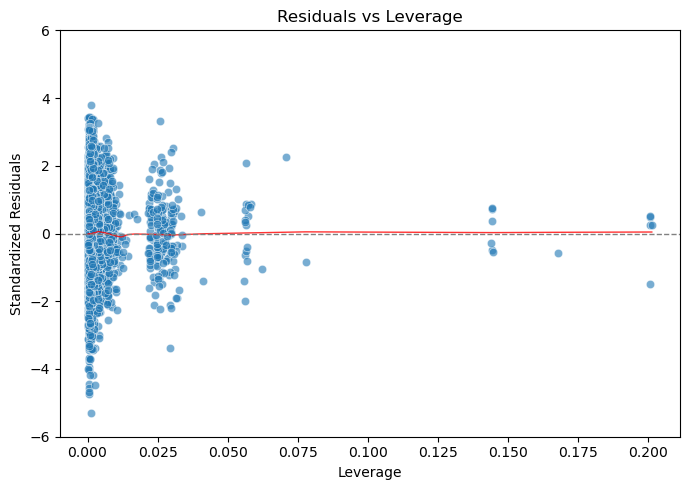

In [11]:
influence = mdf.get_influence()
leverage = influence.hat_matrix_diag
residuals = influence.resid_studentized_internal

# Compute Cook's distance and parameters
cooks_d = influence.cooks_distance[0]
p = mdf.df_model + 1

# Function for Cook’s D contour, clipped to avoid infinite values
def cooks_contour(c, p, leverage):
    leverage = np.clip(leverage, 1e-5, 1 - 1e-5)
    return np.sqrt((c * p * (1 - leverage)) / leverage)

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=leverage, y=residuals, alpha=0.6)
sns.regplot(x=leverage, y=residuals, lowess=True,
            scatter=False, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Leverage')

# Add Cook’s distance contours (better scaling)
for c in [0.5, 1]:
    curve = cooks_contour(c, p, np.linspace(0.001, max(leverage), 50))
    plt.plot(np.linspace(0.001, max(leverage), 50), curve, 'r--', lw=1)
    plt.plot(np.linspace(0.001, max(leverage), 50), -curve, 'r--', lw=1)
    # plt.text(max(leverage)*0.98, cooks_contour(c, p, max(leverage)*0.98),
    #          f"Cook's D={c}", color='red', ha='right')
plt.ylim(-6, 6)
plt.tight_layout()
plt.show()

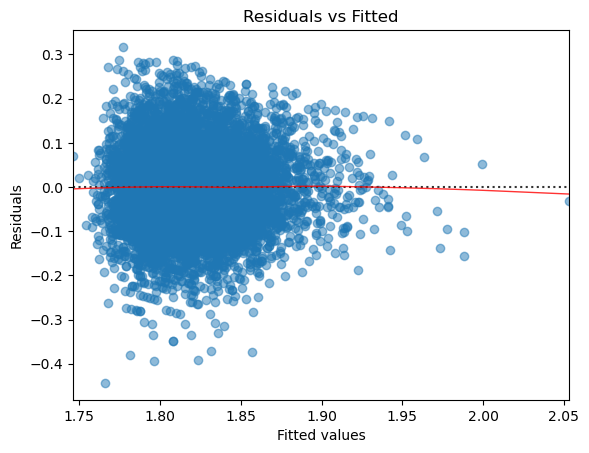

In [12]:

sns.residplot(x=mdf.fittedvalues, y=mdf.resid, 
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');

<Axes: >

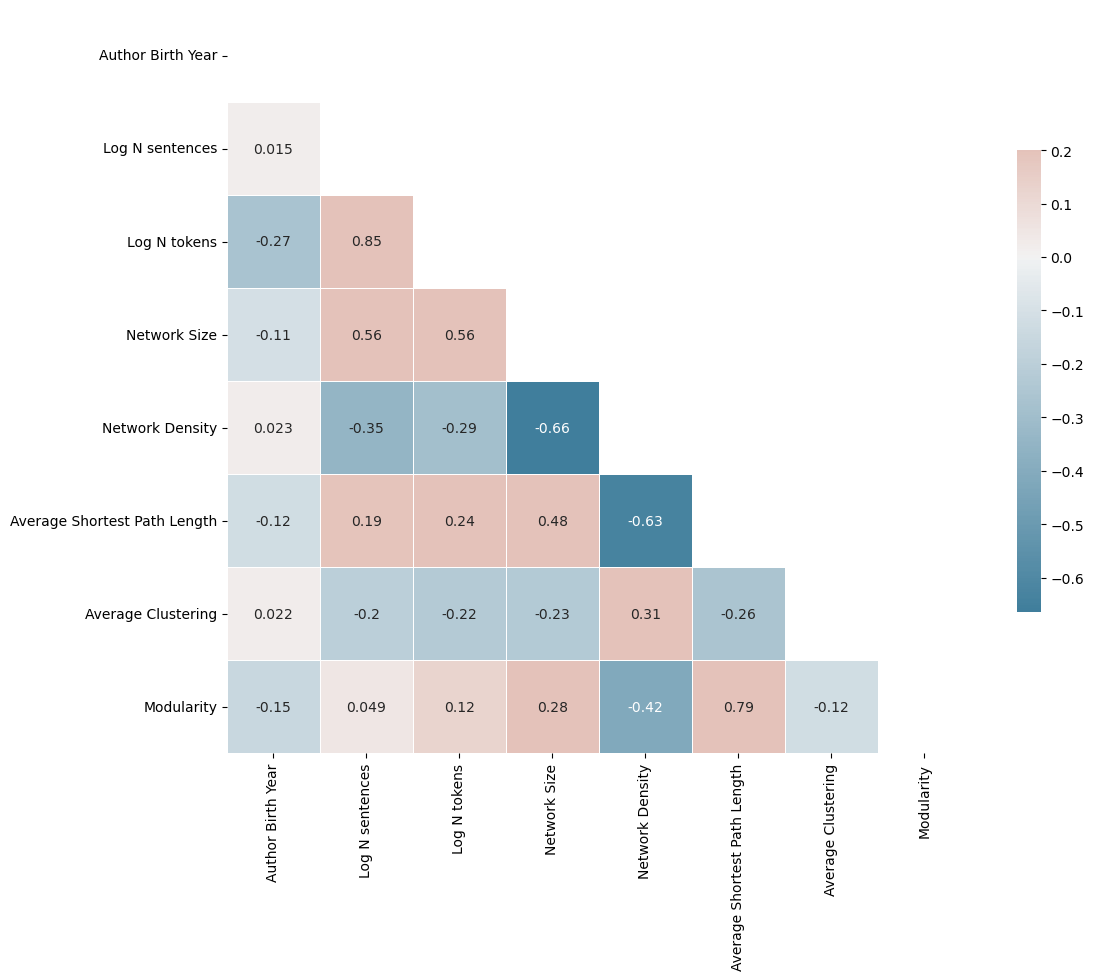

In [13]:
# Compute the correlation matrix
corr = meta_df[["authoryearofbirth","log_N_sentences", "log_N_tokens" , 
                "n_nodes",  "network_density","average_shortest_path_largest_component", "average_clustering", "modularity", 
                ]].corr()
                        # "small_world_omega", "log_small_world_sigma",
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

var_labels = ["Author Birth Year", "Log N sentences", "Log N tokens", "Network Size", "Network Density", "Average Shortest Path Length", "Average Clustering", "Modularity"]
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,
           xticklabels=var_labels, yticklabels=var_labels)

